---
---
---
## Imports

In [1]:
# Data handling and visualization
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data preparation
from sklearn.model_selection import train_test_split

# Pipeline building
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.compose import ColumnTransformer

# Cross-validation and evaluation metrics
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, average_precision_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifier algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Under & over-sampling algorithms
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

---
---
### **Evaluation Metrics**

***Recall***  
Recall is the primary metric in this binary classification problem. In fraud detection it is extremely important to correctly identify as many as possible, or close to all fraudulent transactions. Therefore recall will be the key metric.

***Precision***  
Creating a model with very high recall will usually have to trade-off for some loss in precision, especially when the dataset is highly imbalanced. As a lower level of precision will likely lead to an increase in false positives, the additional costs would need to be considered for the models specific deployment and productivization case. Precision will need to considered as an important secondary metric. Some foreseen drawbacks of lower precision:
- Higher servicing costs in verifying.
- Extra inconvenience to legitimate customers.

***F1 Score***  
F1 score provides useful insight into the balance and tradeoff between recall and precision, allowing for more rapid evaluation of cross validation results.

---
### **Why PR-AUC and not ROC-AUC?**

ROC: Receiver Operating Characteristic  
PR: Precision Recall  
AUC: Area Under Curve  

Due to the enormous imblance in the classes, an ROC-AUC score is not such an appropriate metric of model performance on the test set as:
- ROC curves plot the True Positive Rate (TPR) against the False Positive Rate (FPR)
- In highly imbalanced datasets, the majority class (in this case 'Not Fraud') dominates the FPR, which can make the curve look good even if the model rarely predicts the minority class.
- If the model just predicts Not Fraud for every case, FPR is still low because the negative (Not Fraud) class is so large relative the positive (fraud) class.
- Therefore ROC-AUC can still be high even if the model is failing to detect the minority class.
- ROC-AUC doesnt directly measure how well the model separates the minority class, and both classes get treated equally.
- So a model with high ROC-AUC can still have poor recall for minority class, which is a critically important performance metric in fraud detection!

PR-AUC is a much more appropriate metric:
- It focusses on the positive (in this case minority) class.
- It consider the precision (TP/(TP+FP)) and recall (TP/(TP+FN)), which is very important when developing a real world application for a classification model.
- Not using the majority class in the denominator means that simply not predicting the minority class will give a low PR-AUC score and therefore better reflect the models overall performance. 

I will include both metrics in my evaluations to try to exemplify these ideas but will pay closer attention to PR-AUC score.

---
---
## **Data Preparation**
#### 1. Load Data

In [6]:
data = pd.read_csv('../data/creditcard.csv')
data = data.drop_duplicates()
data['Class'] = data['Class'].astype('bool')

#### 2. Train, Test Split

In [7]:
train, test = train_test_split(data, test_size=0.3, stratify=data['Class'], random_state=13)

#### 3. Define Target & X, y Pairs

In [245]:
target = 'Class'

X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

# Had to retrospectively cast y_train and test as int for SMOTEENN to work in evaluations.
y_train = y_train.astype(int)
y_test = y_test.astype(int)

---
---
## **Baseline Testing**

This projects is an investigation of some of SKLearn's built in oversampling and undersampling algorithms. Before these can be tested and evaluated baseline metrics need to be generated through cross validation with the training set.

In [263]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=13)
xgb = XGBClassifier(objective='binary:logistic', random_state=13)

algorithms = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb
    }

scorers = {
    "Recall": make_scorer(recall_score, average="binary"),
    "Precision": make_scorer(precision_score, average="binary"),
    "F1 Score": make_scorer(f1_score, average="binary"),
    "PR-AUC": make_scorer(average_precision_score, response_method='predict'),
    "ROC-AUC": make_scorer(roc_auc_score, response_method='predict')
}

preprocessor_v1 = ColumnTransformer(transformers=[('drop_cols', 'drop', ['Time', 'Amount'])], remainder='passthrough')

In [187]:
def cross_validate_models(X, y, algorithms={}, pipe_steps=[], preprocessor='v1', cv=5, scorers=None, return_cm=False):
    """
    Performs cross-validation on multiple models, generates confusion matrices, and returns evaluation metrics.
    
    Parameters:
        X, y: Features and target labels.
        algorithms: Dictionary of models, e.g., {'Logistic Regression': model1, 'Random Forest': model2}.
        pipe_steps: Steps for preprocessing pipeline.
        preprocessor: Preprocessing strategy ('v1' uses a default ColumnTransformer).
        cv: Number of cross-validation folds.
        scorers: Dictionary of scoring metrics.
        return_conf_matrices: If True, returns confusion matrices instead of classification reports.

    Returns:
        results_df: DataFrame with confusion matrix values and evaluation metrics.
        conf_matrices: Dictionary containing confusion matrices for each model.
    """
    
    # Use StratifiedKFold for better class balance in folds
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Set default scorers
    if scorers is None:
        scorers = {'Recall': make_scorer(recall_score, average="binary")}
    else:
        scorers = scorers

    results = {
        'Model': [],
        'Fit Time': []}

    conf_matrices = {}

    for name, alg in algorithms.items():
        # Select the correct preprocessor
        if preprocessor == 'v1':
            preprocessor = ColumnTransformer([
                ('drop_cols', 'drop', ['Time', 'Amount'])],
                remainder='passthrough')
        else:
            preprocessor = preprocessor

        # Adjust and complete pipelines
        steps = pipe_steps.copy()
        if preprocessor is not None:
            steps.insert(0, ('preprocessor', preprocessor))
        steps.append(('classifier', alg))

        # Create pipeline
        pipe = imbPipe(steps=steps)

        # Cross validate using StratifiedKFold
        print(f'Cross validating {name}...')
        cv_scores = cross_validate(pipe, X=X, y=y, scoring=scorers, cv=cv_strategy)

        # Extract correct metric keys
        metric_keys = [f'test_{metric}' for metric in scorers.keys()]
        scorer_keys = list(scorers.keys())

        # Store results for the current model
        results['Model'].append(name)
        results['Fit Time'].append(round(np.mean(cv_scores['fit_time']), 2))

        for metric, key in zip(scorer_keys, metric_keys):
            if metric not in results:
                results[metric] = []  
            results[metric].append(round(np.mean(cv_scores[key]), 2))  

        # Generate confusion matrix if requested
        if return_cm:
            print(f'Generating confusion matrix for {name}...')
            y_pred = cross_val_predict(pipe, X, y, cv=cv_strategy)
            cm = confusion_matrix(y, y_pred)
            conf_matrices[name] = cm
        
            if return_cm and 'True Negative' not in results.keys():
                results.update({
                    'True Negative': [],
                    'False Positive': [],
                    'False Negative': [],
                    'True Positive': [],
                })

            results['True Negative'].append(cm[0, 0])
            results['False Positive'].append(cm[0, 1])
            results['False Negative'].append(cm[1, 0])
            results['True Positive'].append(cm[1, 1])

    print('--- Cross Validation Complete ---')
    results_df = pd.DataFrame(results).set_index('Model')

    return (results_df, conf_matrices) if return_cm else results_df

---
---
## Baseline Metrics

Check all three classifier algorithms with all sampling techniques

In [198]:
baseline_DF, baseline_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=[], preprocessor='v1', scorers=scorers, return_cm=True)

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


In [235]:
baseline_DF.to_csv('../data/baseline_cv.csv')
baseline_DF

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,0.93,0.60,0.85,0.70,0.51,0.80,198242,35,133,198
Random Forest,342.67,0.79,0.94,0.86,0.74,0.90,198259,18,69,262
XGBoost,2.96,0.78,0.94,0.85,0.74,0.89,198260,17,72,259


## Baseline Takeaway

Given that running trials on all models is computationally expensive, top 3 models based on the previously discussed evaluation metrics will be used for the following sampling trials. The top 3 models are:
1. XGBoost
2. Random Forest
3. Logistic Regression

Despite the Gaussian Naive Bayes (GNB) model achieving the highest recall score (0.83), the precision was extremely low and likely considered far too costly to use this model in production. 

The GNB model also highlighted how ROC-AUC can be a particularly misleading metric to use with an imbalanced dataset. Although the precision was extremely low, the ROC-AUC score was still extremely high (0.98), however this model has clearly not learnt to separate the classes effectively and achieved a relatively high recall by simply predicting a very high frequency of the positive class. This performance is better reflected by the extremely low PR-AUC score of 0.09.

Similarly, this effect can be seen in the results of the Logistic Regression (LR) model, which when excluding the GNB model, had the lowest recall score of 0.60 and and precision score of 0.84. However, LR achieved the highest ROC-AUC score, but the lowest PR-AUC score.

This results help to exemplify the previously discussed issue of using ROC-AUC as a metric for model performance on an imbalanced dataset.

---
---
## Sampling Trials

The following section aims to trial some of ImbalancedLearn's built-in undersampling and oversampling techniques. All techniques will be applied using the IL version of Pipeline to ensure there is no data leakage into the test folds during cross validation.

Due to computational and time constraints, only the best performing sampling strategy and classifier combination will then move onto the next phase of model devlopment which will include a hyperparameter gridsearch of both the sampling strategy and classifier hyperparameters. In a near perfect scenario with greater resources in both time and computational power, this grid search could be performed for all sampling strategy and classifier combinations.

In [261]:
algorithms = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb
    }

rus = RandomUnderSampler(sampling_strategy=0.3, random_state=13)
smote = SMOTE(sampling_strategy=0.3, random_state=13)

smote2 = SMOTE(sampling_strategy=0.2, random_state=13)

# smote_tl = SMOTE(sampling_strategy=0.2, random_state=13)
tl = TomekLinks(n_jobs=-1)
smotetl = SMOTETomek(sampling_strategy=0.3, random_state=13, smote=smote2, tomek=tl, n_jobs=-1)

# smote_enn = SMOTE(sampling_strategy=0.2, random_state=13)
enn = EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=3, kind_sel='mode')
smoteenn = SMOTEENN(sampling_strategy=0.3, random_state=13, smote=smote2, enn=enn, n_jobs=-1)

nm = NearMiss(sampling_strategy=0.7, version=1, n_neighbors=3)

pipelines = {
    'No Sampling': [],
    'RUS': [('rus', rus)],
    'SMOTE': [('smote', smote)],
    'SMOTE+RUS': [('smote', smote2), ('rus', rus)],
    'SMOTETomek': [('smotetl', smotetl)],
    'SMOTEENN': [('smoteenn', smoteenn)],
    }

---
## Random Under Sampling (RUS)

Needs some explanation of how random under sampler works

In [190]:
rus_df, rus_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['RUS'], preprocessor='v1', scorers=scorers, return_cm=True)
rus_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,0.17,0.89,0.12,0.22,0.11,0.94,196155,2122,36,295
Random Forest,1.16,0.87,0.24,0.37,0.21,0.93,197314,963,42,289
XGBoost,0.61,0.89,0.15,0.26,0.14,0.94,196568,1709,37,294


---
## Synthetic Minority Oversampling Technique (SMOTE)

Needs the exxplanation of how SMOTE works

In [191]:
smote_df, smote_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTE'], preprocessor='v1', scorers=scorers, return_cm=True)
smote_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,1.56,0.89,0.18,0.30,0.16,0.94,196919,1358,38,293
Random Forest,258.15,0.82,0.89,0.85,0.73,0.91,198242,35,59,272
XGBoost,6.22,0.83,0.82,0.82,0.68,0.92,198216,61,56,275


---
## SMOTE & Random Under Sampling

Needs explanation of how the SMOTE works

In [264]:
smote_rus_df, smote_rus_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTE+RUS'], preprocessor='v1', scorers=scorers, return_cm=True)
smote_rus_df

Cross validating Logistic Regression...


Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,5.34,0.88,0.18,0.29,0.16,0.94,196904,1373,39,292
Random Forest,107.78,0.82,0.86,0.84,0.70,0.91,198232,45,60,271
XGBoost,2.30,0.84,0.80,0.81,0.67,0.92,198205,72,54,277


---
## SMOTE & Tomek Links

A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003).

The process of SMOTE-Tomek Links is as follows.

**SMOTE**:
- Choose random data from the minority class.
- Calculate the distance between the random data and its k nearest neighbors.
- Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
- Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).

**Tomek Links**: 
- Choose random data from the majority class.
- If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

To achieve a similar 70:30 ratio of majority to minority class, smotetomek smapling_strategy needs to be lower than the sampling_strategy set in the smote object so that the tomek object can remove majority samples and bring the final ratio to 70:30 without generating too many synthetic minority samples.

tomek links is very expensive computationlly. It would therefore need to provide a significantly improved model or require the use of gpu to ensure efficieny and scalability.

In [193]:
smotetomek, smotetomek_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTETomek'], preprocessor='v1', scorers=scorers, return_cm=True)
smotetomek

Cross validating Logistic Regression...


Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,99.46,0.87,0.25,0.39,0.22,0.93,197383,894,42,289
Random Forest,461.53,0.82,0.90,0.86,0.74,0.91,198245,32,58,273
XGBoost,206.81,0.82,0.83,0.82,0.68,0.91,198220,57,58,273


- Illustrates the massive increase in computational demand and cost.
- Didn't provide sufficiently significant improvement in evaluation metrics that would warrant this level of time/computation-performance tradeoff in this scenario.

---
## SMOTE & Edited Nearest Neighbors (ENN)
- Identifies each samples k nearest neighbors (based on Euclidean distances). 
- If a sample's class is different to the majority of its kNN, the sample is considered 'misclassified'.
- These misclassified samples are removed from the dataset.
- `kind_sel` param has all, or mode as args. 'all' removes samples if ***any*** knn belong to different class. 'mode' removes a sample is ***the majority*** of its knn belong to a different class.

In [194]:
smoteenn_df, smoteenn_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTETomek'], preprocessor='v1', scorers=scorers, return_cm=True)
smoteenn_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
--- Cross Validation Complete ---


,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,148.99,0.87,0.25,0.39,0.22,0.93,197383,894,42,289
Random Forest,298.99,0.82,0.90,0.86,0.74,0.91,198245,32,58,273
XGBoost,133.85,0.82,0.83,0.82,0.68,0.91,198220,57,58,273


---
## Train Set Sampling Trial Evaluation

In [255]:
def concat_metrics(scores_dict):
    df_list = []
    
    for sampling, df in scores_dict.items():
        temp_df = df.copy().reset_index()
        temp_df['Sampling'] = sampling
        
        cols = ['Model', 'Sampling'] + [col for col in temp_df.columns if col not in ['Model', 'Sampling']]
        temp_df = temp_df[cols]
        
        df_list.append(temp_df)
    
    final_df = pd.concat(df_list, ignore_index=True).set_index(['Model','Sampling'])

    final_df = final_df.sort_index(level=['Model','Sampling'])
    
    return final_df

In [196]:
def plot_confusion_matrices(cm_dict, model_names, cmap='Purples'):
    
    rows = len(model_names)
    cols = len(cm_dict)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*5))

    for col, (sampling, cms) in enumerate(cm_dict.items()):
        for row, model in enumerate(model_names):
            ax = axes[row, col]

            cm = cms[model]
            ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud']).plot(ax=ax, cmap='Purples', values_format='d')

            if row == 0:
                ax.set_title(sampling)
            if col == 0:
                ax.set_ylabel(model)

    plt.suptitle('Confusion Matrices for Each Model Sampling Technique Combination on the Training Dataset', fontsize=18, y=1.01)
    plt.tight_layout()
    plt.show()

    return fig

In [268]:
train_scores = {
    'Baseline': baseline_DF,
    'Random Under Sampling': rus_df,
    'SMOTE': smote_df,
    'SMOTE + RUS': smote_rus_df,
    'SMOTETomek': smotetomek,
    'SMOTEENN': smoteenn_df
}

train_cms = {
    'Baseline': baseline_cms,
    'Random Under Sampling': rus_cms,
    'SMOTE': smote_cms,
    'SMOTE + RUS': smote_rus_cms,
    'SMOTETomek': smotetomek_cms,
    'SMOTEENN': smoteenn_cms
}

In [265]:
train_scores_df = concat_metrics(train_scores)

In [269]:
train_scores_df

Fit Time  Recall  Precision  \
Model               Sampling                                             
Logistic Regression Baseline                   0.93    0.60       0.85   
                    Random Under Sampling      0.17    0.89       0.12   
                    SMOTE                      1.56    0.89       0.18   
                    SMOTE + RUS                1.42    0.89       0.18   
                    SMOTEENN                 148.99    0.87       0.25   
                    SMOTETomek                99.46    0.87       0.25   
Random Forest       Baseline                 342.67    0.79       0.94   
                    Random Under Sampling      1.16    0.87       0.24   
                    SMOTE                    258.15    0.82       0.89   
                    SMOTE + RUS              180.87    0.82       0.89   
                    SMOTEENN                 298.99    0.82       0.90   
                    SMOTETomek               461.53    0.82       0.90   
XGBoost             Baseline                   2.96    0.78       0.94   
                    Random Under Sampling      0.61    0.89       0.15   
                    SMOTE                      6.22    0.83       0.82   
                    SMOTE + RUS                3.01    0.83       0.81   
                    SMOTEENN                 133.85    0.82       0.83   
                    SMOTETomek               206.81    0.82       0.83   

                                           F1 Score  PR-AUC  ROC-AUC  \
Model               Sampling                                           
Logistic Regression Baseline                   0.70    0.51     0.80   
                    Random Under Sampling      0.22    0.11     0.94   
                    SMOTE                      0.30    0.16     0.94   
                    SMOTE + RUS                0.30    0.16     0.94   
                    SMOTEENN                   0.39    0.22     0.93   
                    SMOTETomek                 0.39    0.22     0.93   
Random Forest       Baseline                   0.86    0.74     0.90   
                    Random Under Sampling      0.37    0.21     0.93   
                    SMOTE                      0.85    0.73     0.91   
                    SMOTE + RUS                0.85    0.73     0.91   
                    SMOTEENN                   0.86    0.74     0.91   
                    SMOTETomek                 0.86    0.74     0.91   
XGBoost             Baseline                   0.85    0.74     0.89   
                    Random Under Sampling      0.26    0.14     0.94   
                    SMOTE                      0.82    0.68     0.92   
                    SMOTE + RUS                0.82    0.67     0.92   
                    SMOTEENN                   0.82    0.68     0.91   
                    SMOTETomek                 0.82    0.68     0.91   

                                           True Negative  False Positive  \
Model               Sampling                                               
Logistic Regression Baseline                      198242              35   
                    Random Under Sampling         196155            2122   
                    SMOTE                         196919            1358   
                    SMOTE + RUS                   196919            1358   
                    SMOTEENN                      197383             894   
                    SMOTETomek                    197383             894   
Random Forest       Baseline                      198259              18   
                    Random Under Sampling         197314             963   
                    SMOTE                         198242              35   
                    SMOTE + RUS                   198243              34   
                    SMOTEENN                      198245              32   
                    SMOTETomek                    198245              32   
XGBoost             Baseline                      198260 

In [274]:
train_scores_df.sort_values(by='Recall', ascending=False)

Fit Time  Recall  Precision  \
Model               Sampling                                             
XGBoost             Random Under Sampling      0.61    0.89       0.15   
Logistic Regression SMOTE                      1.56    0.89       0.18   
                    SMOTE + RUS                1.42    0.89       0.18   
                    Random Under Sampling      0.17    0.89       0.12   
                    SMOTEENN                 148.99    0.87       0.25   
                    SMOTETomek                99.46    0.87       0.25   
Random Forest       Random Under Sampling      1.16    0.87       0.24   
XGBoost             SMOTE + RUS                3.01    0.83       0.81   
                    SMOTE                      6.22    0.83       0.82   
Random Forest       SMOTE + RUS              180.87    0.82       0.89   
XGBoost             SMOTEENN                 133.85    0.82       0.83   
                    SMOTETomek               206.81    0.82       0.83   
Random Forest       SMOTETomek               461.53    0.82       0.90   
                    SMOTEENN                 298.99    0.82       0.90   
                    SMOTE                    258.15    0.82       0.89   
                    Baseline                 342.67    0.79       0.94   
XGBoost             Baseline                   2.96    0.78       0.94   
Logistic Regression Baseline                   0.93    0.60       0.85   

                                           F1 Score  PR-AUC  ROC-AUC  \
Model               Sampling                                           
XGBoost             Random Under Sampling      0.26    0.14     0.94   
Logistic Regression SMOTE                      0.30    0.16     0.94   
                    SMOTE + RUS                0.30    0.16     0.94   
                    Random Under Sampling      0.22    0.11     0.94   
                    SMOTEENN                   0.39    0.22     0.93   
                    SMOTETomek                 0.39    0.22     0.93   
Random Forest       Random Under Sampling      0.37    0.21     0.93   
XGBoost             SMOTE + RUS                0.82    0.67     0.92   
                    SMOTE                      0.82    0.68     0.92   
Random Forest       SMOTE + RUS                0.85    0.73     0.91   
XGBoost             SMOTEENN                   0.82    0.68     0.91   
                    SMOTETomek                 0.82    0.68     0.91   
Random Forest       SMOTETomek                 0.86    0.74     0.91   
                    SMOTEENN                   0.86    0.74     0.91   
                    SMOTE                      0.85    0.73     0.91   
                    Baseline                   0.86    0.74     0.90   
XGBoost             Baseline                   0.85    0.74     0.89   
Logistic Regression Baseline                   0.70    0.51     0.80   

                                           True Negative  False Positive  \
Model               Sampling                                               
XGBoost             Random Under Sampling         196568            1709   
Logistic Regression SMOTE                         196919            1358   
                    SMOTE + RUS                   196919            1358   
                    Random Under Sampling         196155            2122   
                    SMOTEENN                      197383             894   
                    SMOTETomek                    197383             894   
Random Forest       Random Under Sampling         197314             963   
XGBoost             SMOTE + RUS                   198210              67   
                    SMOTE                         198216              61   
Random Forest       SMOTE + RUS                   198243              34   
XGBoost             SMOTEENN                      198220              57   
                    SMOTETomek                    198220              57   
Random Forest       SMOTETomek                    198245 

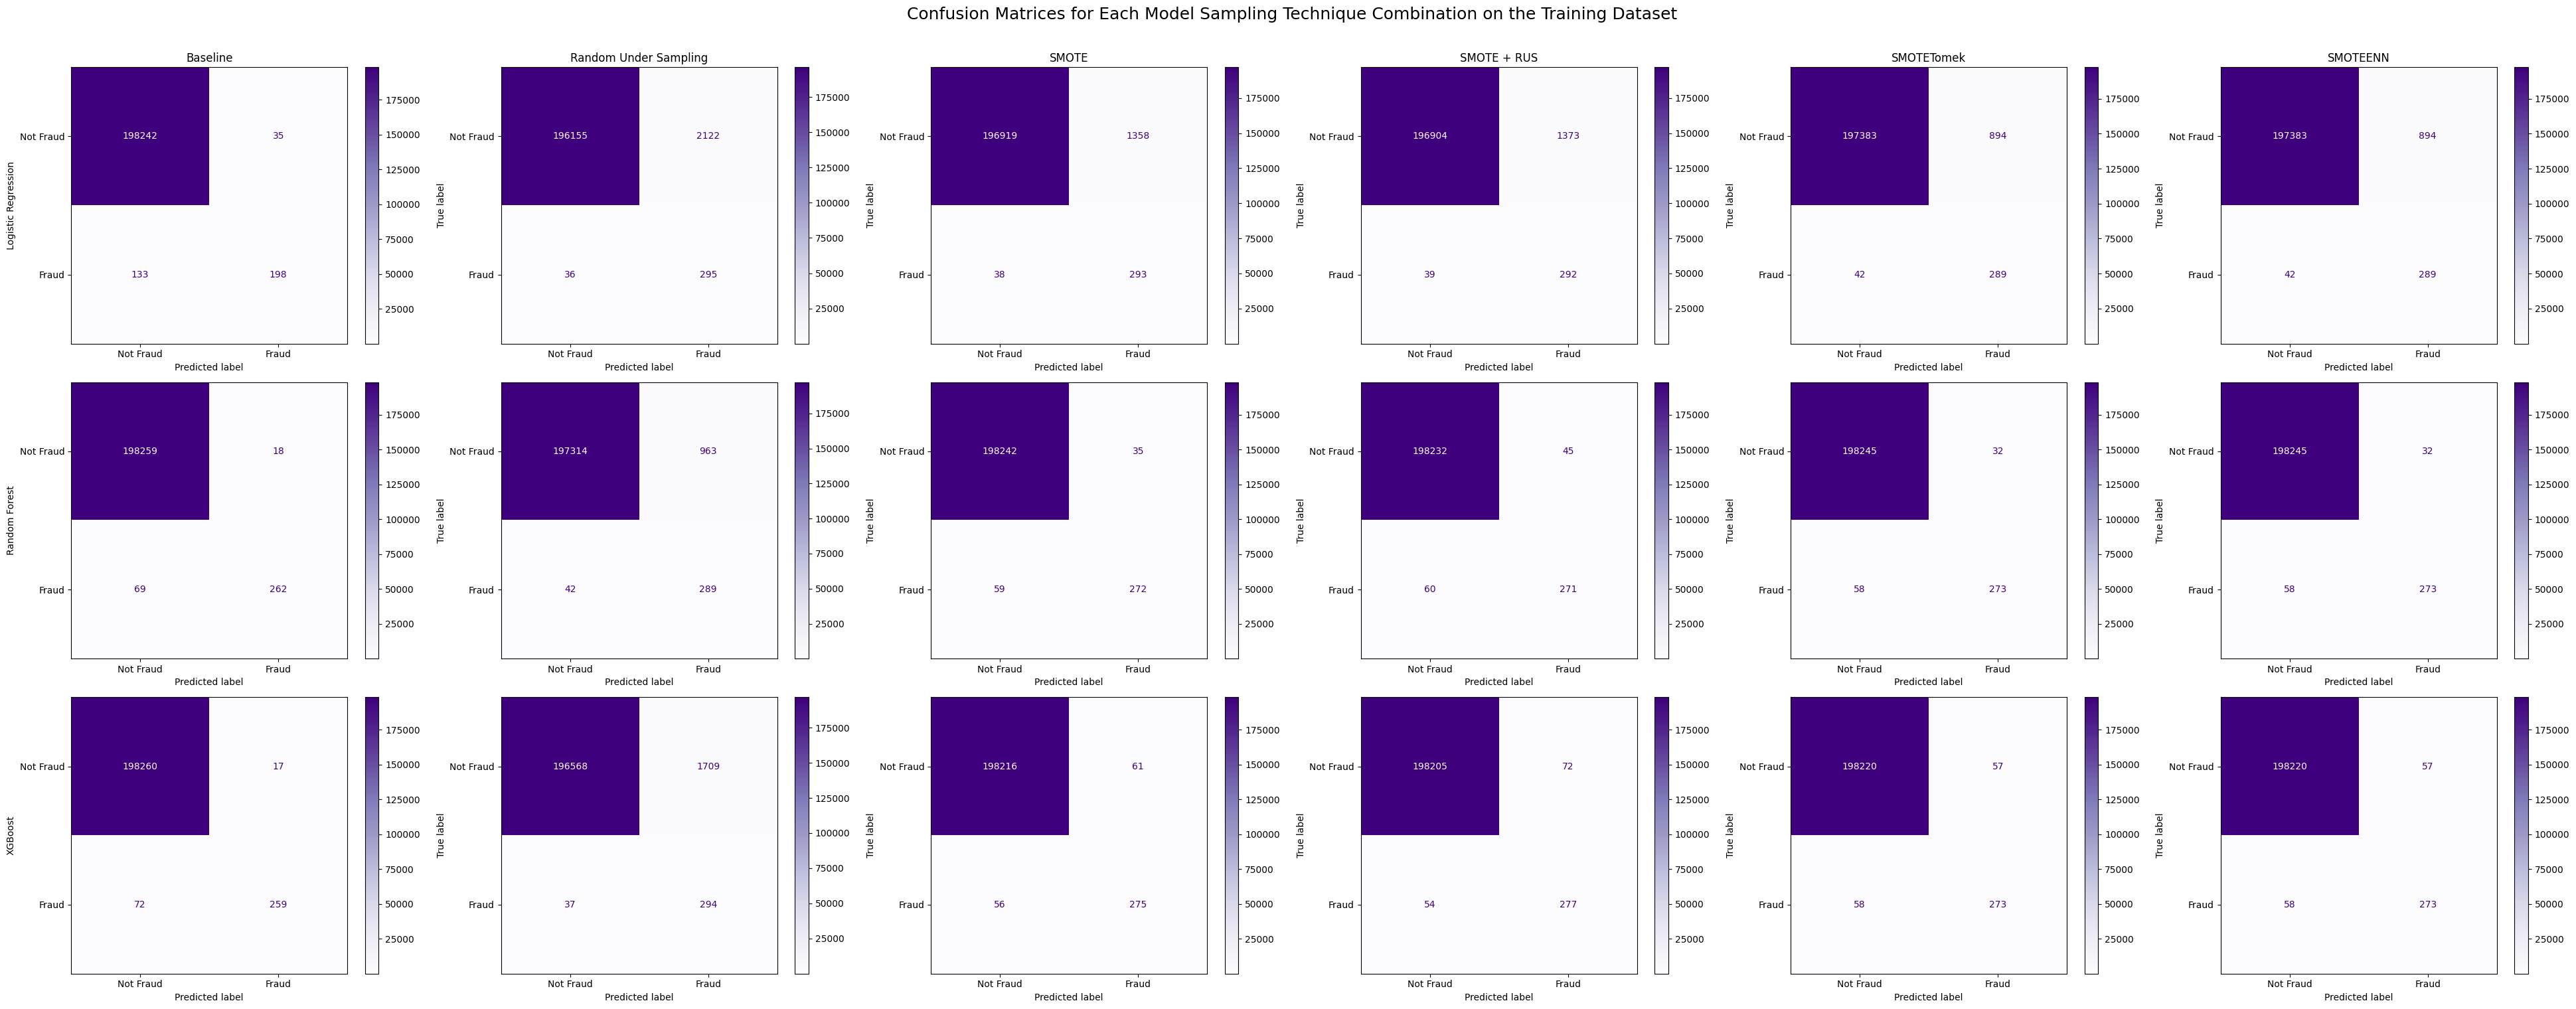

In [271]:
train_cms = plot_confusion_matrices(train_cms, model_names=['Logistic Regression','Random Forest','XGBoost'])

---
---
## Test Set Evaluations
While a test set should really be reserved for the final controlled test of a finished model, it is very useful at this stage to visualize the confusion matrices for each model to more closely investigate how these sampling techniques are impacting the learning process. This could be carried out on a prediction of the training set however this will not help understand the level of overfitting.

Visualizing the confusion matrix for a given model can help to better understand the number of True Positives (TPs), False Positives (FPs), True Negatives (TNs) and False Negatives (FNs). In this fraud detection scenario, we need a model that is primarily achieving the highest number of TPs (actual fraud cases) and the lowest number of FNs (misclassified fraud cases, or slipthroughs). As a secondary line of evaluation and important especially in the scaling and productivization of a model, there should be as few as possible FPs. Here is where fully understanding business and stakeholder needs is crucial to interpreting how to move forward with a given model. 

In [258]:
def evaluate_models(X_train, y_train, X_test, y_test, algorithms, pipelines=None, preprocessor='v1', scorers=None, normalize=None, cmap='Purples'):
    if not pipelines:
        raise ValueError('A dictionary of pipelines must be provided')
    if not algorithms or not isinstance(algorithms, dict):
        raise ValueError('A dictionary of models must be provided e.g. {"logistic Regression": lr()})')
    
    y_true = y_test

    if scorers is None:
        scorers = {'Recall': recall_score}

    cm_dict = {'Model': [],'Sampling': []}
    
    for metric in scorers.keys():
        cm_dict[metric] = []

    cm_dict.update({'True Negative': [],'False Positive': [],'False Negative': [],'True Positive': []})

    num_models = len(algorithms)
    num_pipelines = len(pipelines)

    figsize = (num_pipelines * 6.5, num_models * 5)
    fig, axes = plt.subplots(num_models, num_pipelines, figsize=figsize, squeeze=False)
    for row, (alg_name, alg) in enumerate(algorithms.items()):
        for col, (sampling_name, pipe_steps) in enumerate(pipelines.items()):
            ax = axes[row, col] if num_models > 1 and num_pipelines >1 else axes[max(row, col)]
            pipe_steps = pipe_steps.copy()
            if preprocessor =='v1':
                preproc = preprocessor_v1
            else:
                preproc = preprocessor
            if preproc:
                pipe_steps.insert(0, ('preprocessor', preproc))
            
            pipe_steps.append(('classifier', alg))
            pipe = imbPipe(steps=pipe_steps)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=normalize, values_format='d',
                                                    display_labels=['Not Fraud', 'Fraud'], cmap=cmap, ax=ax)
            
            if row == 0:
                ax.set_title(sampling_name)
            if col == 0:
                ax.set_ylabel(alg_name)

            cm = confusion_matrix(y_true, y_pred).flatten()
            cm_dict['Model'].append(alg_name)
            cm_dict['Sampling'].append(sampling_name)
            cm_dict['True Negative'].append(cm[0])
            cm_dict['False Positive'].append(cm[1])
            cm_dict['False Negative'].append(cm[2])
            cm_dict['True Positive'].append(cm[3])

            for metric, scorer in scorers.items():
                cm_dict[metric].append(round(scorer(y_true, y_pred), 2))

    plt.suptitle('Confusion Matrices for Each Model and Sampling Technique Combination on Test Set', fontsize=18, y=1.01)

    plt.tight_layout()
    plt.show()

    cm_df = pd.DataFrame(cm_dict).set_index(['Model', 'Sampling'])

    return fig, cm_df

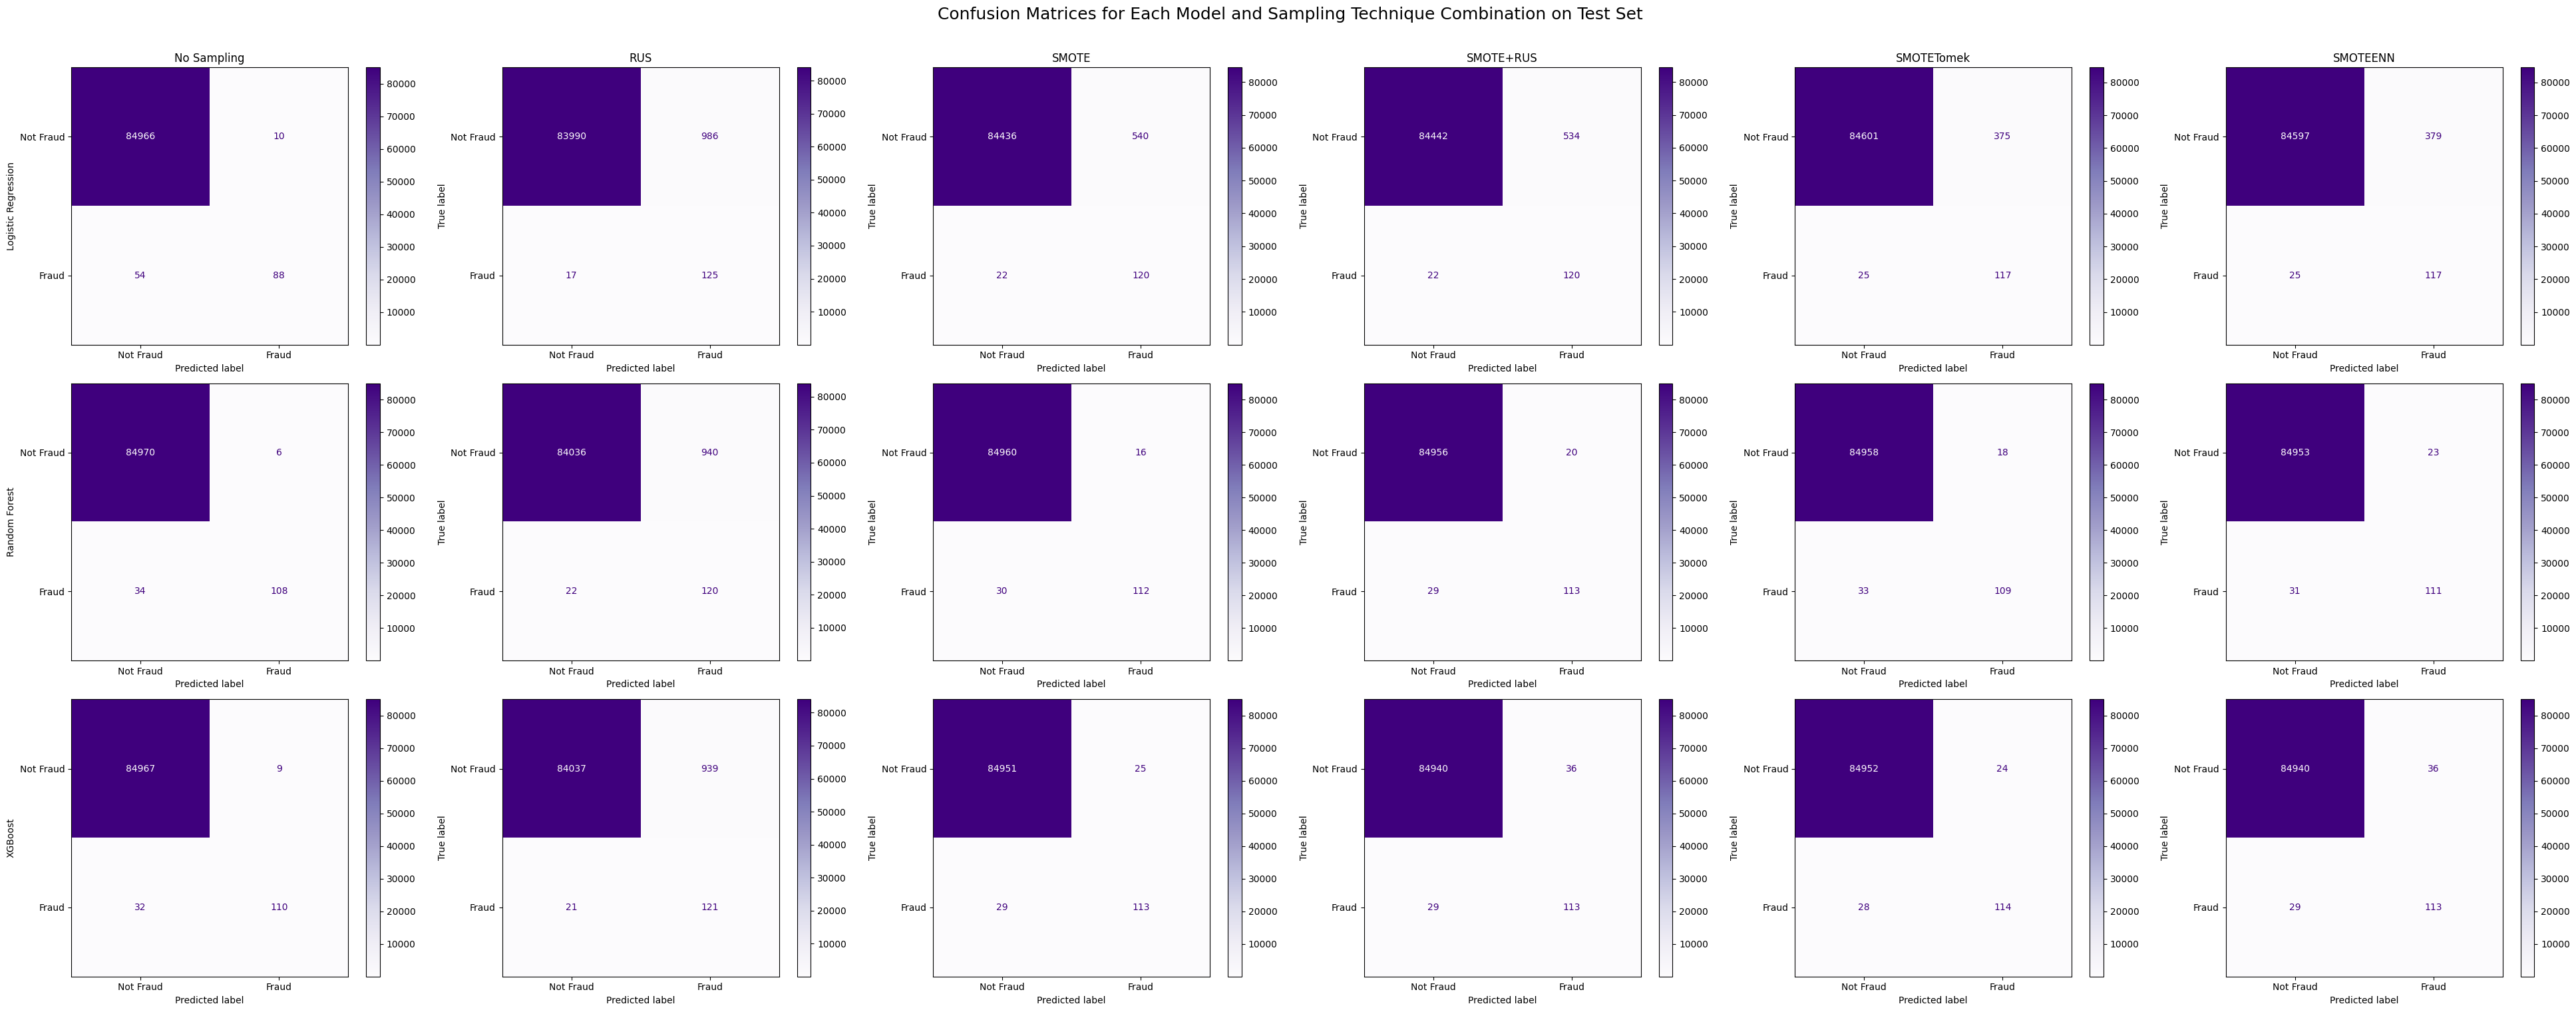

In [277]:
scorers = {
    "Recall": recall_score,
    "Precision": precision_score,
    "F1 Score": f1_score,
    "PR-AUC": average_precision_score,
    "ROC-AUC": roc_auc_score
}

test_cms, test_scores_df = evaluate_models(X_train, y_train, X_test, y_test, algorithms, pipelines=pipelines, scorers=scorers)

In [278]:
# test_scores_df.to_csv('../data/test_scores.csv')

In [279]:
test_scores_df.sort_values(by='True Positive', ascending=False)

Recall  Precision  F1 Score  PR-AUC  ROC-AUC  \
Model               Sampling                                                    
Logistic Regression RUS            0.88       0.11      0.20    0.10     0.93   
XGBoost             RUS            0.85       0.11      0.20    0.10     0.92   
Logistic Regression SMOTE          0.85       0.18      0.30    0.15     0.92   
                    SMOTE+RUS      0.85       0.18      0.30    0.16     0.92   
Random Forest       RUS            0.85       0.11      0.20    0.10     0.92   
Logistic Regression SMOTETomek     0.82       0.24      0.37    0.20     0.91   
                    SMOTEENN       0.82       0.24      0.37    0.19     0.91   
XGBoost             SMOTETomek     0.80       0.83      0.81    0.66     0.90   
Random Forest       SMOTE+RUS      0.80       0.85      0.82    0.68     0.90   
XGBoost             SMOTE+RUS      0.80       0.76      0.78    0.60     0.90   
                    SMOTE          0.80       0.82      0.81    0.65     0.90   
                    SMOTEENN       0.80       0.76      0.78    0.60     0.90   
Random Forest       SMOTE          0.79       0.88      0.83    0.69     0.89   
                    SMOTEENN       0.78       0.83      0.80    0.65     0.89   
XGBoost             No Sampling    0.77       0.92      0.84    0.72     0.89   
Random Forest       SMOTETomek     0.77       0.86      0.81    0.66     0.88   
                    No Sampling    0.76       0.95      0.84    0.72     0.88   
Logistic Regression No Sampling    0.62       0.90      0.73    0.56     0.81   

                                 True Negative  False Positive  \
Model               Sampling                                     
Logistic Regression RUS                  83990             986   
XGBoost             RUS                  84037             939   
Logistic Regression SMOTE                84436             540   
                    SMOTE+RUS            84442             534   
Random Forest       RUS                  84036             940   
Logistic Regression SMOTETomek           84601             375   
                    SMOTEENN             84597             379   
XGBoost             SMOTETomek           84952              24   
Random Forest       SMOTE+RUS            84956              20   
XGBoost             SMOTE+RUS            84940              36   
                    SMOTE                84951              25   
                    SMOTEENN             84940              36   
Random Forest       SMOTE                84960              16   
                    SMOTEENN             84953              23   
XGBoost             No Sampling          84967               9   
Random Forest       SMOTETomek           84958              18   
                    No Sampling          84970               6   
Logistic Regression No Sampling          84966              10   

                                 False Negative  True Positive  
Model               Sampling                                    
Logistic Regression RUS                      17            125  
XGBoost             RUS                      21            121  
Logistic Regression SMOTE                    22            120  
                    SMOTE+RUS                22            120  
Random Forest       RUS                      22            120  
Logistic Regression SMOTETomek               25            117  
                    SMOTEENN                 25            117  
XGBoost             SMOTETomek               28            114  
Random Forest       SMOTE+RUS                29            113  
XGBoost             SMOTE+RUS                29            113  
                    SMOTE                    29            113  
                    SMOTEENN                 29            113  
Random Forest       SMOTE                    30            112  
                    SMOTEENN                 31            111  
XGBoost             No Sampling              32    

In [289]:
test_scores_df.query('Recall >= 0.8 & Precision >= 0.8')

Recall  Precision  F1 Score  PR-AUC  ROC-AUC  \
Model         Sampling                                                   
Random Forest SMOTE+RUS      0.8       0.85      0.82    0.68      0.9   
XGBoost       SMOTE          0.8       0.82      0.81    0.65      0.9   
              SMOTETomek     0.8       0.83      0.81    0.66      0.9   

                          True Negative  False Positive  False Negative  \
Model         Sampling                                                    
Random Forest SMOTE+RUS           84956              20              29   
XGBoost       SMOTE               84951              25              29   
              SMOTETomek          84952              24              28   

                          True Positive  
Model         Sampling                   
Random Forest SMOTE+RUS             113  
XGBoost       SMOTE                 113  
              SMOTETomek            114

## Takeaways
How are the confusion matrices useful for analysing each models performance?

---
---
## Hyperparameter Tuning with BayesSearchCV

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, loguniform

from joblib import dump

In [28]:
grids = {
    'logreg_rus' : {
        'rus__sampling_strategy': uniform(loc=0.2, scale=1.0),
        'classifier__max_iter': randint(500, 5001),
        'classifier__C': loguniform(0.01, 10.0)
        },
                               
    'xgboost_smote' : {
        'smote__sampling_strategy': uniform(loc=0.2, scale=0.8),
        'smote__k_neighbors': randint(3, 8),
        'classifier__n_estimators': randint(100, 501),
        'classifier__max_depth': randint(3, 11),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': uniform(loc=0.6, scale=0.4)
        },

    'rf_smote_rus' : {
        'smote__sampling_strategy': uniform(loc=0.2, scale=0.8),
        'smote__k_neighbors': randint(3, 8),
        'rus__sampling_strategy': uniform(loc=0.2, scale=0.8),
        'classifier__n_estimators': randint(100, 501),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 21),
        'classifier__min_samples_leaf': randint(1, 21)}
}

In [26]:
def random_search_cv(algorithm, pipe_steps, param_grid, preprocessor='v1', scoring='Recall', n_iter=10, cv=5, n_jobs=-1):
    
    if preprocessor == 'v1':
        preproc = ColumnTransformer(
            transformers=[('drop_cols', 'drop', ['Time', 'Amount'])],
            remainder='passthrough')
    else:
        preproc = preprocessor

    steps = pipe_steps.copy()

    if preproc:
        steps.insert(0, ('preprocessor', preproc))

    steps.append(('classifier', algorithm))

    pipe = imbPipe(steps=steps)
    rscv = RandomizedSearchCV(pipe,
                              param_distributions=param_grid,
                              n_iter=n_iter,
                              cv=cv,
                              scoring=scoring,
                              random_state=13,
                              n_jobs=n_jobs)
    
    rscv.fit(X_train, y_train)
    best_params = rscv.best_params_
    best_score = rscv.best_score_
    best_model = rscv.best_estimator_

    return best_model, best_params, best_score

In [29]:
lr_best_model, lr_best_params, lr_best_score = random_search_cv(algorithms['Logistic Regression'], pipe_steps=pipelines['RUS'], param_grid=grids['logreg_rus'], scoring='average_precision')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

In [32]:
lr_best_score

0.6774775322396709

In [45]:
lr_randsearch = lr_best_model
dump(lr_randsearch, '../models/lr_rus.joblib')

['../models/lr_rus.joblib']

In [30]:
xgb_best_model, xgb_best_params, xgb_best_score = random_search_cv(algorithms['XGBoost'], pipe_steps=pipelines['SMOTE'], param_grid=grids['xgboost_smote'], scoring='average_precision')

In [31]:
xgb_best_score

0.854305911775942


In [43]:
xgb_randsearch = xgb_best_model
dump(lr_randsearch, '../models/xgb_smote.joblib')

['../models/xgb_smote.joblib']

In [33]:
rf_best_model, rf_best_params, rf_best_score = random_search_cv(algorithms['Random Forest'], pipe_steps=pipelines['SMOTE+RUS'], param_grid=grids['rf_smote_rus'], scoring='average_precision')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

In [34]:
rf_best_score

0.8431673092855443

In [44]:
rf_randsearch = rf_best_model
dump(lr_randsearch, '../models/rf_smote_rus.joblib')

['../models/rf_smote_rus.joblib']

In [48]:
best_models = {
    'Logistic Regression: RUS': lr_best_model,
    'Random Forest: SMOTE + RUS': rf_best_model,
    'XGBoost: SMOTE': xgb_best_model}

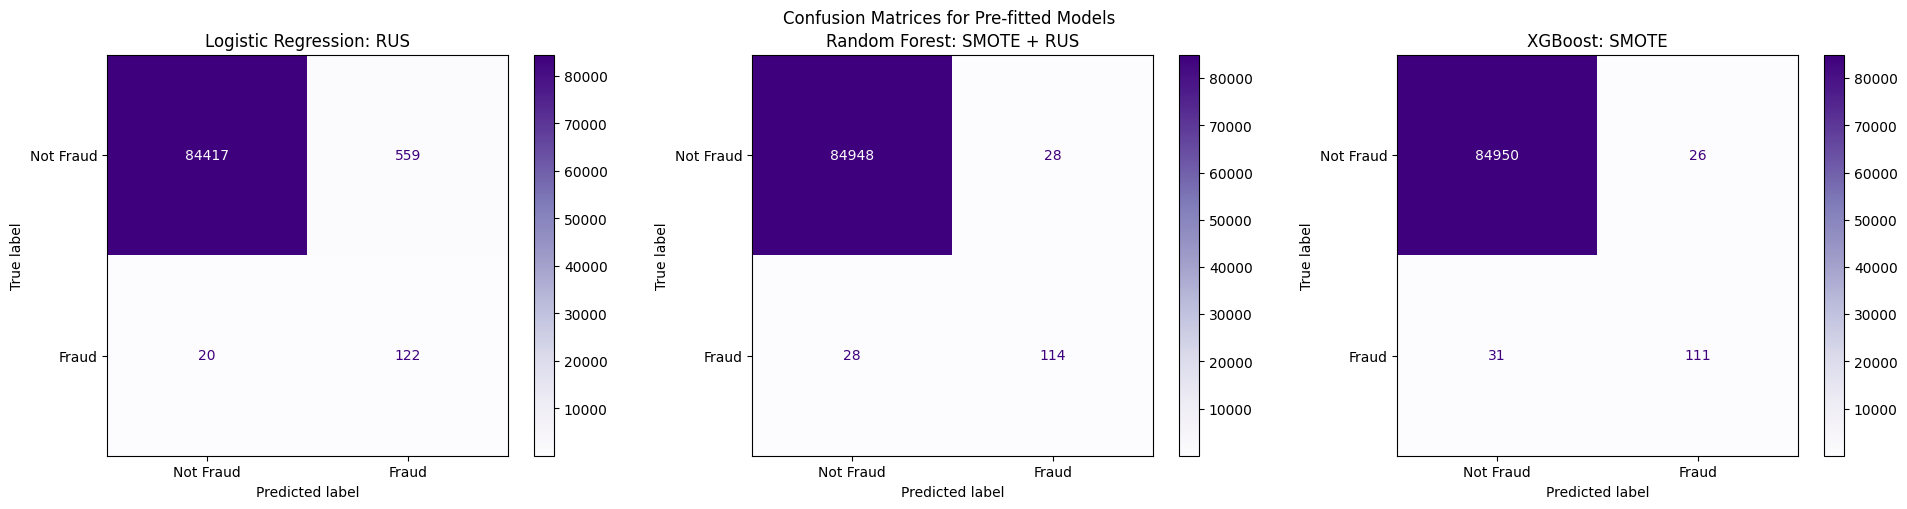

,True Negative,False Positive,False Negative,True Positive,Recall,Precision,F1 Score,PR-AUC
Model,,,,,,,,
Logistic Regression: RUS,84417,559,20,122,0.86,0.18,0.3,0.15
Random Forest: SMOTE + RUS,84948,28,28,114,0.80,0.80,0.8,0.64
XGBoost: SMOTE,84950,26,31,111,0.78,0.81,0.8,0.63


In [52]:
cm_evaluation(X_train, y_train, X_test, y_test, algorithms=best_models, pre_fitted=True, pipelines=None, preprocessor='v1', calculate_scores=True, normalize=None, cmap='Purples', cols=3)

---
---
## pr-curve vs roc-curve

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay

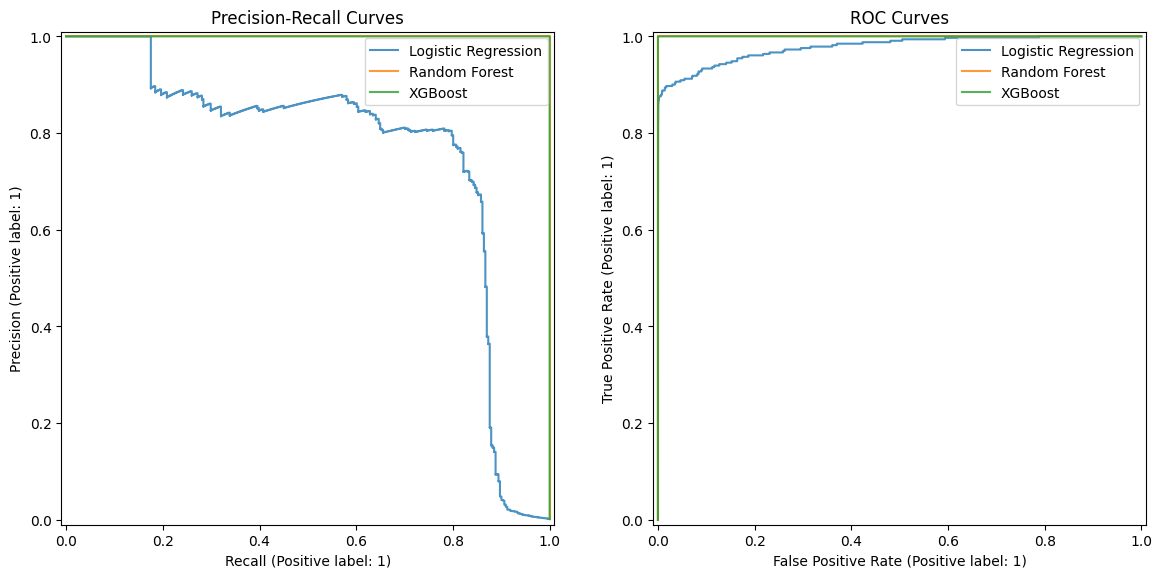

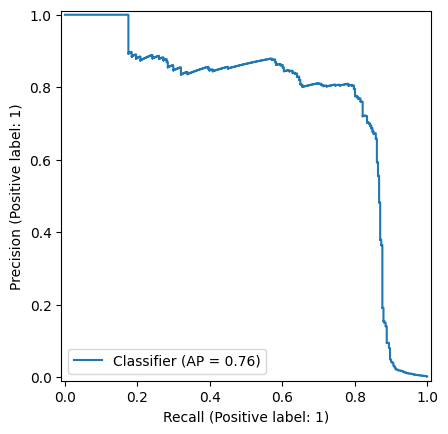

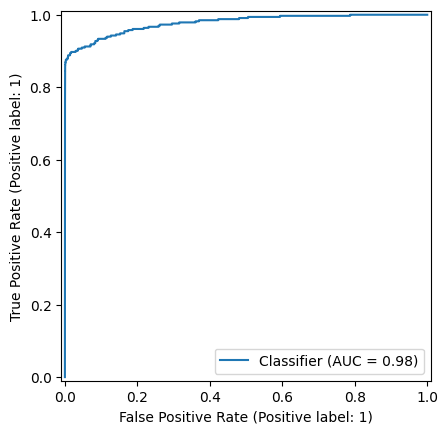

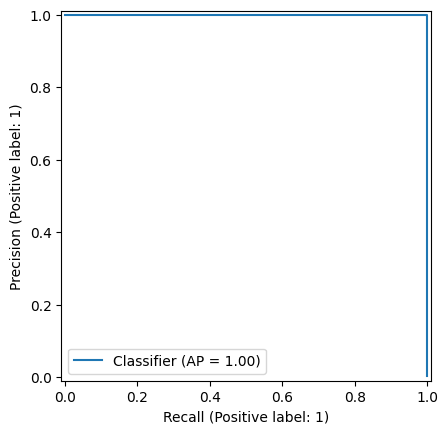

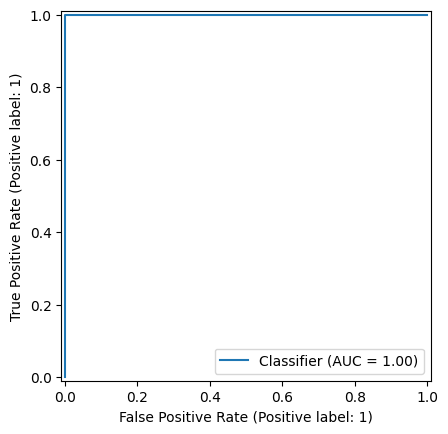

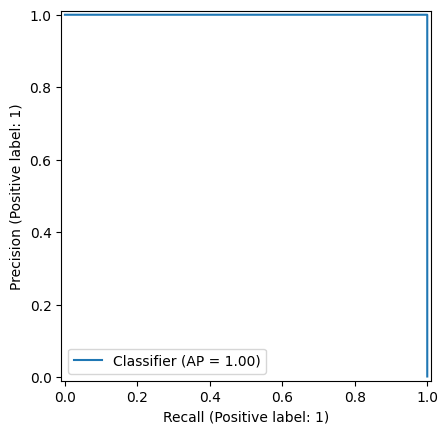

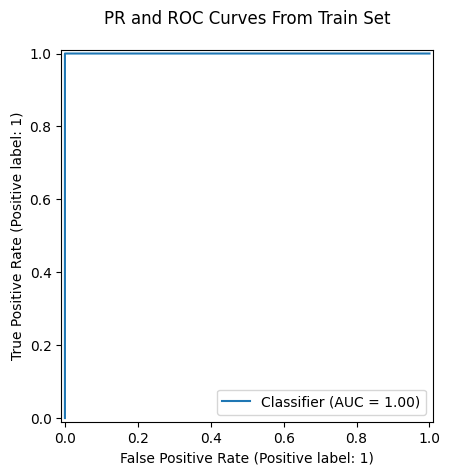

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax_pr, ax_roc = axes

for i, (name, alg) in enumerate(algorithms.items()):
    if name == 'SVC':
        continue
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', alg)])
    
    pipe.fit(X_train, y_train)
    y_probas = pipe.predict_proba(X_train)[:,1]

    pr_disp = PrecisionRecallDisplay.from_predictions(y_train, y_probas)
    roc_disp = RocCurveDisplay.from_predictions(y_train, y_probas)

    pr_disp.plot(ax=ax_pr, alpha=0.8, label=f'{name}')
    roc_disp.plot(ax=ax_roc, alpha=0.8, label=f'{name}')

ax_pr.set_title('Precision-Recall Curves')
ax_pr.legend()

ax_roc.set_title('ROC Curves')
ax_roc.legend()

plt.suptitle('PR and ROC Curves From Train Set')

plt.tight_layout()
plt.show()

In [42]:
lr.fit(X_train, y_train)
y_probas = lr.predict_proba(X_train)[:,1]

precision, recall, thresholds = precision_recall_curve(y_train, y_probas)
avg_precision = average_precision_score(y_train, y_probas)
lr_disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision, estimator_name='Logistic Regression', pos_label='Fraud')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
